<a href="https://colab.research.google.com/github/ubeL13/Lab1/blob/main/LAB5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from plotly.offline import iplot
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from google.colab import files
import torch.optim as optim
import io
from datetime import datetime

device = "cuda"

In [ ]:
torch.cuda.is_available()

True

#1 загрузка даннных

In [ ]:
data_to_load = files.upload()
print(data_to_load)

Saving dataset.csv to dataset (3).csv
{'dataset (3).csv': b'1998-04-20,,,,0,771,\xd0\xa8\r\n2000-09-13,0,740,\xd0\xa1\xd0\x97 3\xd0\xbc/\xd1\x81,,,\r\n2008-01-10,-20,765,\xd0\x92 2\xd0\xbc/\xd1\x81,-22,765,\xd0\x92 2\xd0\xbc/\xd1\x81\r\n2008-01-11,-20,764,\xd0\xa8,-24,764,\xd0\xa8\r\n2008-01-12,-20,762,\xd0\x97 2\xd0\xbc/\xd1\x81,-20,761,\xd0\x97 2\xd0\xbc/\xd1\x81\r\n2008-01-13,-9,756,\xd0\xae\xd0\x97 3\xd0\xbc/\xd1\x81,-7,754,\xd0\xae\xd0\x97 3\xd0\xbc/\xd1\x81\r\n2008-01-14,-6,751,\xd0\xae\xd0\x97 2\xd0\xbc/\xd1\x81,-4,752,\xd0\xae\xd0\x97 2\xd0\xbc/\xd1\x81\r\n2008-01-15,-1,753,\xd0\x97 1\xd0\xbc/\xd1\x81,-2,754,\xd0\x97 1\xd0\xbc/\xd1\x81\r\n2008-01-16,-1,759,\xd0\xa8,-2,762,\xd0\xa8\r\n2008-01-17,-4,765,\xd0\xae 3\xd0\xbc/\xd1\x81,-4,765,\xd0\xae 3\xd0\xbc/\xd1\x81\r\n2008-01-18,-8,765,\xd0\xae 1\xd0\xbc/\xd1\x81,-10,765,\xd0\xae 1\xd0\xbc/\xd1\x81\r\n2008-01-19,-9,765,\xd0\xa8,-12,765,\xd0\xa8\r\n2008-01-20,-9,762,\xd0\xae 3\xd0\xbc/\xd1\x81,-14,762,\xd0\xae 3\xd0\xbc/\xd1\x81\r

In [ ]:
import io
dframe = pd.read_csv(io.BytesIO(data_to_load['dataset (3).csv']), names=[
            "Date",
            "Temperature",
            "Presure_morning",
            "Wind_morning",
            "Temp_evening",
            "Presure_evening",
            "Wind_evening",
        ])
df = dframe.iloc[:, :2]

df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
if not df.index.is_monotonic_increasing:
    df = df.sort_index()
df = df.dropna() if not ((df.isnull().sum()).eq(0).all()) else df
print(df)

            Temperature
Date                   
2000-09-13          0.0
2000-09-13          0.0
2008-01-10        -20.0
2008-01-11        -20.0
2008-01-12        -20.0
...                 ...
2023-11-01         12.0
2023-11-02         13.0
2023-11-03          6.0
2023-11-04          5.0
2023-11-05          6.0

[5699 rows x 1 columns]


In [ ]:
def plot_dataset(df:pd.DataFrame , title:str)->None:
    '''
    График датафрейма
    Args:
      df: pd.DataFrame;
      title: str;

    Return:
      None
    '''
    data = []

    value = go.Scatter(
        x=df.index,
        y=df.Temperature,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Temperature", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

plot_dataset(df,"Temperature changes")

In [ ]:
def generate_time_lags(df: pd.DataFrame, n_lags: int) -> pd.DataFrame:
    '''
    Функция генерирует временные задержки (лаги) на основе прошлых значений.
    Args:
      df: pd.DataFrame;
      n_lags: int;

    Return:
      DataFrame
    '''
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["Temperature"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

input_dim = 100

df_timelags = generate_time_lags(df, input_dim)
print(df_timelags)

            Temperature  lag1  lag2  lag3  lag4  lag5  lag6  lag7  lag8  lag9  \
Date                                                                            
2008-04-17         11.0   8.0   8.0   9.0  20.0  21.0  22.0  21.0  20.0  19.0   
2008-04-18         12.0  11.0   8.0   8.0   9.0  20.0  21.0  22.0  21.0  20.0   
2008-04-19         12.0  12.0  11.0   8.0   8.0   9.0  20.0  21.0  22.0  21.0   
2008-04-20         15.0  12.0  12.0  11.0   8.0   8.0   9.0  20.0  21.0  22.0   
2008-04-21         19.0  15.0  12.0  12.0  11.0   8.0   8.0   9.0  20.0  21.0   
...                 ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2023-11-01         12.0  11.0   2.0   6.0   2.0  -1.0   1.0  -1.0  11.0   5.0   
2023-11-02         13.0  12.0  11.0   2.0   6.0   2.0  -1.0   1.0  -1.0  11.0   
2023-11-03          6.0  13.0  12.0  11.0   2.0   6.0   2.0  -1.0   1.0  -1.0   
2023-11-04          5.0   6.0  13.0  12.0  11.0   2.0   6.0   2.0  -1.0   1.0   
2023-11-05          6.0   5.

<ipython-input-87-6a26f1b95f97>:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



#2 разделение загруженного набора данных

In [ ]:
def feature_label_split(df: pd.DataFrame, target_col: str):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df, target_col):
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.1, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, test_size=0.1, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_timelags, 'Temperature')

In [ ]:
X, y = feature_label_split(df, 'Temperature')
print(X)
print(y)
print(X_train)
print(X_val)
print(X_test)

Empty DataFrame
Columns: []
Index: [2000-09-13 00:00:00, 2000-09-13 00:00:00, 2008-01-10 00:00:00, 2008-01-11 00:00:00, 2008-01-12 00:00:00, 2008-01-13 00:00:00, 2008-01-14 00:00:00, 2008-01-15 00:00:00, 2008-01-16 00:00:00, 2008-01-17 00:00:00, 2008-01-18 00:00:00, 2008-01-19 00:00:00, 2008-01-20 00:00:00, 2008-01-21 00:00:00, 2008-01-22 00:00:00, 2008-01-23 00:00:00, 2008-01-24 00:00:00, 2008-01-25 00:00:00, 2008-01-26 00:00:00, 2008-01-27 00:00:00, 2008-01-28 00:00:00, 2008-01-29 00:00:00, 2008-01-30 00:00:00, 2008-01-31 00:00:00, 2008-02-01 00:00:00, 2008-02-02 00:00:00, 2008-02-03 00:00:00, 2008-02-04 00:00:00, 2008-02-05 00:00:00, 2008-02-06 00:00:00, 2008-02-07 00:00:00, 2008-02-08 00:00:00, 2008-02-09 00:00:00, 2008-02-10 00:00:00, 2008-02-11 00:00:00, 2008-02-12 00:00:00, 2008-02-13 00:00:00, 2008-02-14 00:00:00, 2008-02-15 00:00:00, 2008-02-16 00:00:00, 2008-02-17 00:00:00, 2008-02-18 00:00:00, 2008-02-19 00:00:00, 2008-02-20 00:00:00, 2008-02-21 00:00:00, 2008-02-22 00:00:00

#3 прогнозирования временных рядов

In [ ]:
def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [ ]:
scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)
y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [ ]:
print(X_train)
print(X_train_arr)

            lag1  lag2  lag3  lag4  lag5  lag6  lag7  lag8  lag9  lag10  ...  \
Date                                                                     ...   
2008-04-17   8.0   8.0   9.0  20.0  21.0  22.0  21.0  20.0  19.0   20.0  ...   
2008-04-18  11.0   8.0   8.0   9.0  20.0  21.0  22.0  21.0  20.0   19.0  ...   
2008-04-19  12.0  11.0   8.0   8.0   9.0  20.0  21.0  22.0  21.0   20.0  ...   
2008-04-20  12.0  12.0  11.0   8.0   8.0   9.0  20.0  21.0  22.0   21.0  ...   
2008-04-21  15.0  12.0  12.0  11.0   8.0   8.0   9.0  20.0  21.0   22.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...    ...  ...   
2018-03-17  -2.0  -5.0  -7.0  -8.0  -7.0  -9.0  -4.0  -4.0  -8.0   -8.0  ...   
2018-03-18  -6.0  -2.0  -5.0  -7.0  -8.0  -7.0  -9.0  -4.0  -4.0   -8.0  ...   
2018-03-19  -8.0  -6.0  -2.0  -5.0  -7.0  -8.0  -7.0  -9.0  -4.0   -4.0  ...   
2018-03-20 -10.0  -8.0  -6.0  -2.0  -5.0  -7.0  -8.0  -7.0  -9.0   -4.0  ...   
2018-03-21  -1.0 -10.0  -8.0  -6.0  -2.0

#4

In [ ]:
batch_size = 128
learning_rate = 0.001

In [ ]:
train_features = torch.Tensor(X_train_arr).to("cuda:0")
train_targets = torch.Tensor(y_train_arr).to("cuda:0")
val_features = torch.Tensor(X_val_arr).to("cuda:0")
val_targets = torch.Tensor(y_val_arr).to("cuda:0")
test_features = torch.Tensor(X_test_arr).to("cuda:0")
test_targets = torch.Tensor(y_test_arr).to("cuda:0")

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

5

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, layer_dim: int, output_dim: int, dropout_prob: float) -> None:
        """The __init__ method that initiates an RNN instance.

        Args:
            input_dim (int): The number of nodes in the input layer(входной слой)
            hidden_dim (int): The number of nodes in each layer(скрытый слой)
            layer_dim (int): The number of layers in the network(кол-во слоев нейронки)
            output_dim (int): The number of nodes in the output layer(выходной слой)
            dropout_prob (float): The probability of nodes being dropped out(вер-ть исключить эл-т)

        """
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(
            0), self.hidden_dim).requires_grad_().to("cuda:0")

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [ ]:
class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """
    def __init__(self, model, loss_fn, optimizer):
        """
        Args:
            model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
            loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
            optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        """
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x, y):
        """The method train_step completes one step of training.

        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        Args:
            x (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size, n_epochs=50, n_features=1):
        """The method train performs the model training

        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. If early stopping is enabled, then it  checks the stopping condition
        to decide whether the training needs to halt before n_epochs steps. Finally, it saves
        the model in a designated file path.

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader that stores training data
            val_loader (torch.utils.data.DataLoader): DataLoader that stores validation data
            batch_size (int): Batch size for mini-batch training
            n_epochs (int): Number of epochs, i.e., train steps, to train
            n_features (int): Number of feature columns

        """
        model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        Args:
            test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
            batch_size (int): Batch size for mini-batch training
            n_features (int): Number of feature columns

        Returns:
            list[float]: The values predicted by the model
            list[float]: The actual values in the test set.

        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to('cpu').detach().numpy())
                values.append(y_test.to('cpu').detach().numpy())

        return predictions, values

    def plot_losses(self):
        """The method plots the calculated loss values for training and validation
        """
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

[1/20] Training loss: 0.0626	 Validation loss: 0.0167
[2/20] Training loss: 0.0130	 Validation loss: 0.0063
[3/20] Training loss: 0.0093	 Validation loss: 0.0054
[4/20] Training loss: 0.0087	 Validation loss: 0.0051
[5/20] Training loss: 0.0082	 Validation loss: 0.0049
[6/20] Training loss: 0.0077	 Validation loss: 0.0051
[7/20] Training loss: 0.0073	 Validation loss: 0.0047
[8/20] Training loss: 0.0074	 Validation loss: 0.0049
[9/20] Training loss: 0.0067	 Validation loss: 0.0043
[10/20] Training loss: 0.0070	 Validation loss: 0.0044


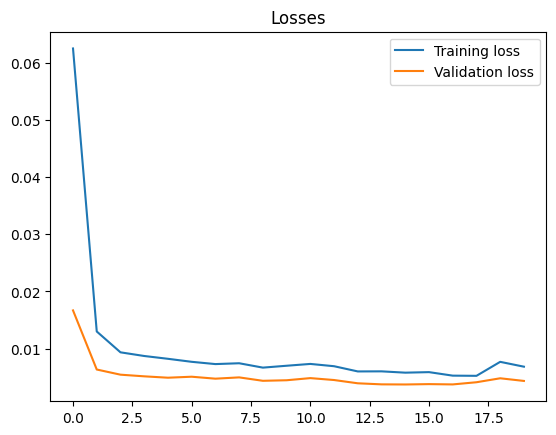

In [ ]:
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = batch_size
layer_dim = 3
dropout = 0.2
n_epochs = 20
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = RNNModel(**model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

Для batch_size = 64 и learning_rate = 0.1
```
[1/20] Training loss: 1.2653	 Validation loss: 0.0779
[2/20] Training loss: 0.3407	 Validation loss: 0.2800
[3/20] Training loss: 0.5333	 Validation loss: 0.3037
[4/20] Training loss: 0.5601	 Validation loss: 0.2005
[5/20] Training loss: 0.5862	 Validation loss: 0.1926
[6/20] Training loss: 0.6012	 Validation loss: 0.1900
[7/20] Training loss: 0.6064	 Validation loss: 0.1907
[8/20] Training loss: 0.6096	 Validation loss: 0.1833
[9/20] Training loss: 0.6097	 Validation loss: 0.1936
[10/20] Training loss: 0.6111	 Validation loss: 0.1938

```
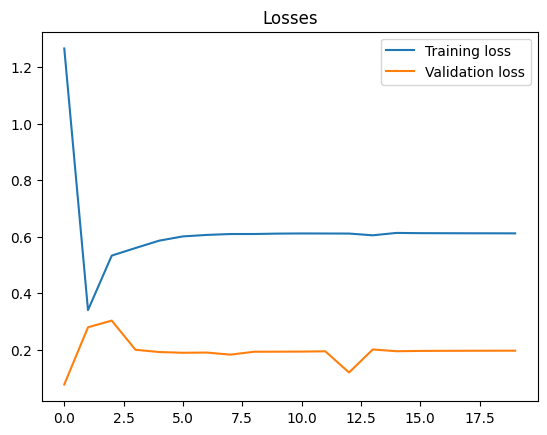

#6

Для batch_size = 64 и learning_rate = 0.01
```
[[1/20] Training loss: 0.0938	 Validation loss: 0.0098
[2/20] Training loss: 0.0233	 Validation loss: 0.0136
[3/20] Training loss: 0.0204	 Validation loss: 0.0056
[4/20] Training loss: 0.0102	 Validation loss: 0.0050
[5/20] Training loss: 0.0097	 Validation loss: 0.0054
[6/20] Training loss: 0.0096	 Validation loss: 0.0056
[7/20] Training loss: 0.0131	 Validation loss: 0.0057
[8/20] Training loss: 0.0098	 Validation loss: 0.0061
[9/20] Training loss: 0.0186	 Validation loss: 0.0134
[10/20] Training loss: 0.1849	 Validation loss: 0.0517
```
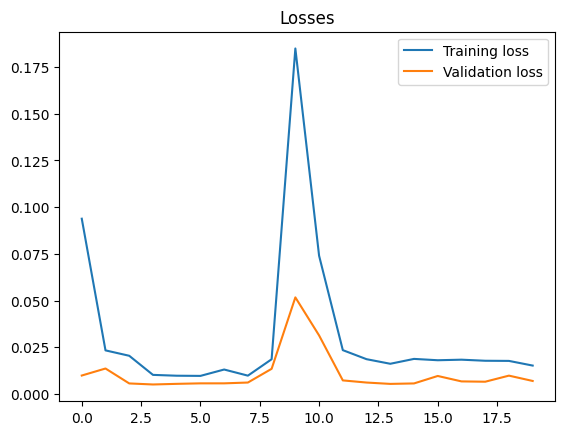

Для batch_size = 64 и learning_rate = 0.001
```
[1/20] Training loss: 0.0441	 Validation loss: 0.0070
[2/20] Training loss: 0.0110	 Validation loss: 0.0055
[3/20] Training loss: 0.0098	 Validation loss: 0.0053
[4/20] Training loss: 0.0099	 Validation loss: 0.0051
[5/20] Training loss: 0.0088	 Validation loss: 0.0057
[6/20] Training loss: 0.0101	 Validation loss: 0.0052
[7/20] Training loss: 0.0089	 Validation loss: 0.0048
[8/20] Training loss: 0.0086	 Validation loss: 0.0065
[9/20] Training loss: 0.0095	 Validation loss: 0.0046
[10/20] Training loss: 0.0076	 Validation loss: 0.0048
```
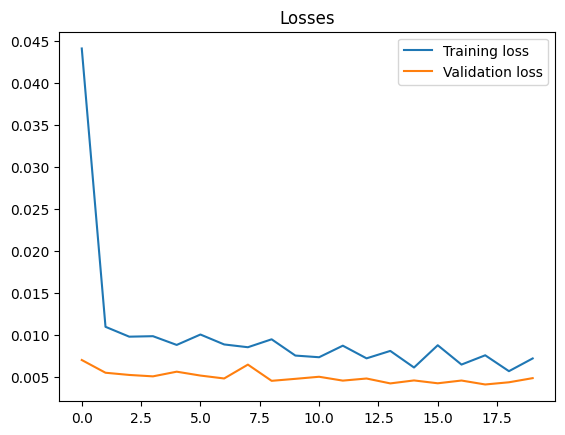

Для batch_size = 96 и learning_rate = 0.1
```
[1/20] Training loss: 1.0523	 Validation loss: 0.0628
[2/20] Training loss: 0.2211	 Validation loss: 0.0482
[3/20] Training loss: 0.3142	 Validation loss: 0.0526
[4/20] Training loss: 0.4156	 Validation loss: 0.1162
[5/20] Training loss: 0.4646	 Validation loss: 0.1405
[6/20] Training loss: 0.4676	 Validation loss: 0.1341
[7/20] Training loss: 0.4601	 Validation loss: 0.1284
[8/20] Training loss: 0.4575	 Validation loss: 0.1278
[9/20] Training loss: 0.4573	 Validation loss: 0.1288
[10/20] Training loss: 0.4578	 Validation loss: 0.1293
```
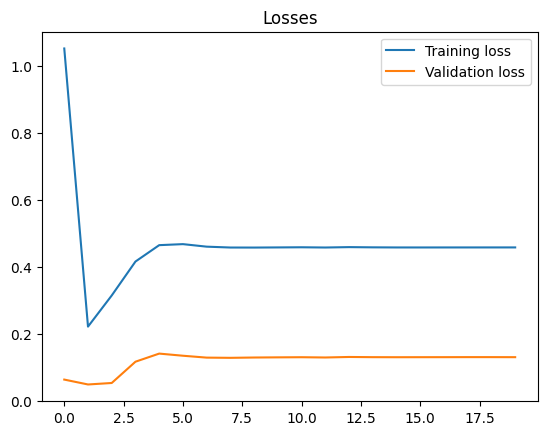

Для batch_size = 96 и learning_rate = 0.01
```
[1/20] Training loss: 0.2754	 Validation loss: 0.0546
[2/20] Training loss: 0.0405	 Validation loss: 0.0078
[3/20] Training loss: 0.0151	 Validation loss: 0.0055
[4/20] Training loss: 0.0122	 Validation loss: 0.0057
[5/20] Training loss: 0.0103	 Validation loss: 0.0050
[6/20] Training loss: 0.0126	 Validation loss: 0.0048
[7/20] Training loss: 0.0133	 Validation loss: 0.0064
[8/20] Training loss: 0.0110	 Validation loss: 0.0066
[9/20] Training loss: 0.0096	 Validation loss: 0.0049
[10/20] Training loss: 0.0120	 Validation loss: 0.0071
```
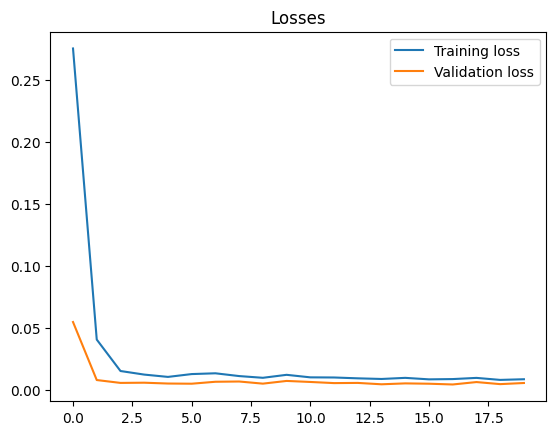



Для batch_size = 96 и learning_rate = 0.001
```
[1/20] Training loss: 0.0589	 Validation loss: 0.0140
[2/20] Training loss: 0.0124	 Validation loss: 0.0055
[3/20] Training loss: 0.0097	 Validation loss: 0.0053
[4/20] Training loss: 0.0086	 Validation loss: 0.0056
[5/20] Training loss: 0.0079	 Validation loss: 0.0050
[6/20] Training loss: 0.0077	 Validation loss: 0.0049
[7/20] Training loss: 0.0077	 Validation loss: 0.0044
[8/20] Training loss: 0.0072	 Validation loss: 0.0044
[9/20] Training loss: 0.0070	 Validation loss: 0.0043
[10/20] Training loss: 0.0070	 Validation loss: 0.0048
```
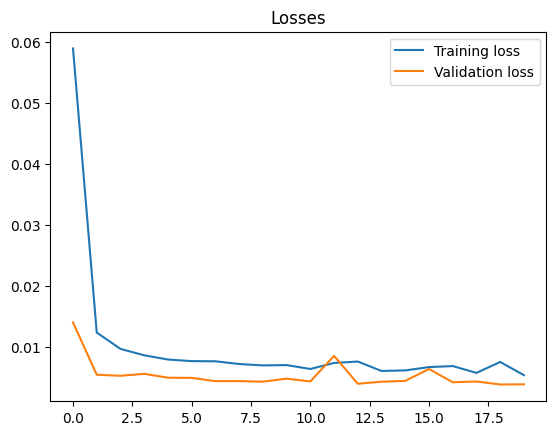

Для batch_size = 128 и learning_rate = 0.1
```
[1/20] Training loss: 1.6136	 Validation loss: 0.4669
[2/20] Training loss: 0.2705	 Validation loss: 0.0518
[3/20] Training loss: 0.1570	 Validation loss: 0.2437
[4/20] Training loss: 0.2990	 Validation loss: 0.0893
[5/20] Training loss: 0.2911	 Validation loss: 0.2215
[6/20] Training loss: 0.3987	 Validation loss: 0.3583
[7/20] Training loss: 0.4583	 Validation loss: 0.3983
[8/20] Training loss: 0.4664	 Validation loss: 0.3655
[9/20] Training loss: 0.4577	 Validation loss: 0.3311
[10/20] Training loss: 0.4460	 Validation loss: 0.3275
```
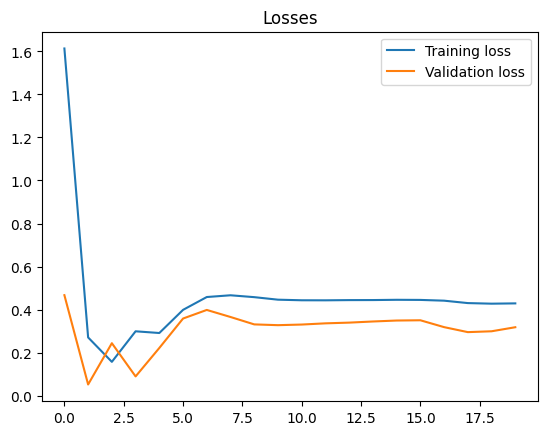

Для batch_size = 128 и learning_rate = 0.01
```
[1/20] Training loss: 0.6925	 Validation loss: 0.0398
[2/20] Training loss: 0.0627	 Validation loss: 0.0392
[3/20] Training loss: 0.0369	 Validation loss: 0.0085
[4/20] Training loss: 0.0212	 Validation loss: 0.0075
[5/20] Training loss: 0.0134	 Validation loss: 0.0070
[6/20] Training loss: 0.0103	 Validation loss: 0.0052
[7/20] Training loss: 0.0103	 Validation loss: 0.0048
[8/20] Training loss: 0.0116	 Validation loss: 0.0049
[9/20] Training loss: 0.0125	 Validation loss: 0.0052
[10/20] Training loss: 0.0126	 Validation loss: 0.0049
```
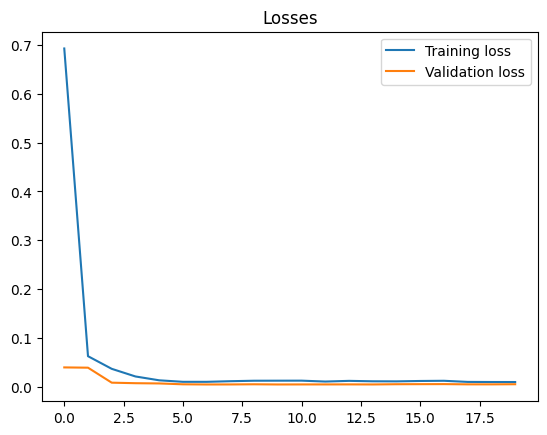

Для batch_size = 128 и learning_rate = 0.001

```
[1/20] Training loss: 0.0802	 Validation loss: 0.0184
[2/20] Training loss: 0.0201	 Validation loss: 0.0058
[3/20] Training loss: 0.0110	 Validation loss: 0.0051
[4/20] Training loss: 0.0099	 Validation loss: 0.0051
[5/20] Training loss: 0.0092	 Validation loss: 0.0047
[6/20] Training loss: 0.0084	 Validation loss: 0.0046
[7/20] Training loss: 0.0082	 Validation loss: 0.0045
[8/20] Training loss: 0.0075	 Validation loss: 0.0044
[9/20] Training loss: 0.0077	 Validation loss: 0.0044
[10/20] Training loss: 0.0072	 Validation loss: 0.0043
```
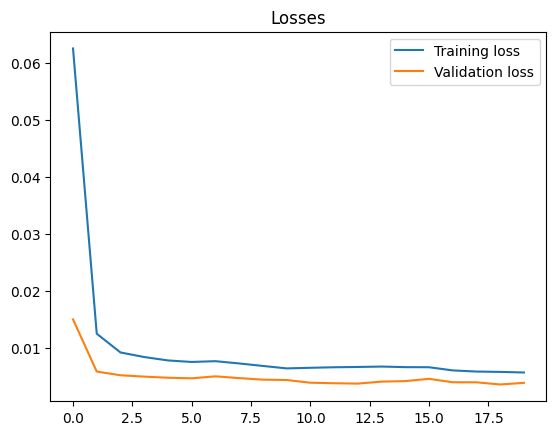


In [ ]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        col_values = df[col].to_numpy().reshape(-1, 1)
        df[col] = scaler.inverse_transform(col_values).ravel()
    return df

def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    vals = vals.reshape(-1, 1)
    preds = preds.reshape(-1, 1)
    df_result = pd.DataFrame(data={"value": vals.flatten(), "prediction": preds.flatten()}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, ["value", "prediction"])
    df_result = df_result.round({"value": 0, "prediction": 0})
    return df_result

df_result = format_predictions(predictions, values, X_test, scaler)
df_result

,value,prediction
Date,,
2020-10-07,18.0,12.0
2020-10-08,15.0,13.0
2020-10-09,15.0,11.0
2020-10-10,15.0,11.0
2020-10-11,15.0,10.0
...,...,...
2022-04-19,21.0,13.0
2022-04-20,17.0,15.0
2022-04-21,9.0,15.0


In [ ]:
def calculate_metrics(df):
    df_cleaned = df.dropna(subset=['value', 'prediction'])

    result_metrics = {'mae': mean_absolute_error(df_cleaned.value, df_cleaned.prediction),
                      'rmse': mean_squared_error(df_cleaned.value, df_cleaned.prediction) ** 0.5,
                      'r2': r2_score(df_cleaned.value, df_cleaned.prediction)}

    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])

    return result_metrics

result_metrics = calculate_metrics(df_result)

Mean Absolute Error:        3.8232143
Root Mean Squared Error:    4.743981212263553
R^2 Score:                  0.8941130788236935


In [ ]:
def temp_by_month(df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    df = df.reset_index(inplace=False)
    start_date = pd.to_datetime(start_date, format='%Y-%m-%d')
    end_date = pd.to_datetime(end_date, format='%Y-%m-%d')
    return df[(start_date <= df["Date"]) & (df["Date"] <= end_date)]


temp_by_month(df_result, "2022-01-01", "2022-02-1")

,Date,value,prediction
447,2022-01-01,-4.0,-10.0
448,2022-01-02,-3.0,-8.0
449,2022-01-03,-11.0,-7.0
450,2022-01-04,-15.0,-9.0
451,2022-01-05,-16.0,-11.0
452,2022-01-06,-7.0,-12.0
453,2022-01-07,-0.0,-10.0
454,2022-01-08,-8.0,-8.0
455,2022-01-09,-11.0,-8.0
456,2022-01-10,-12.0,-9.0


<Axes: xlabel='Date'>

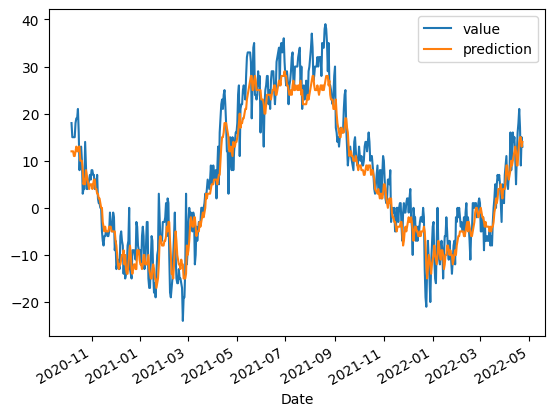

In [ ]:
df_result.plot()